In [17]:
# Credit to https://github.com/mikhailsirenko/bivariate-choropleth for the template 
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from adjustText import adjust_text
import contextily as ctx
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.mstats import winsorize
from scipy.stats import zscore

In [18]:
# PUT DIRECTORY HERE
global_dir = 'Put your directory here'


In [19]:
def read_hhd():
    hhd_url = "https://stats.bis.org/api/v2/data/dataflow/BIS/WS_TC/2.0/Q.AR+AT+AU+BE+BR+CA+CH+CL+CN+CO+CZ+DE+DK+ES+FI+FR+GB+GR+HK+HU+ID+IE+IL+IN+IT+JP+KR+LU+MX+MY+NL+NO+NZ+PL+PT+RU+SA+SE+SG+TH+TR+US+XM+ZA.H.A.M.770.A?startPeriod=1947-01-01&endPeriod=2024-10-26&format=csv"
    hhd_df = pd.read_csv(hhd_url)
    hhd_df = hhd_df[['BORROWERS_CTY', 'TIME_PERIOD', 'OBS_VALUE']].rename(columns={'BORROWERS_CTY': 'Code', 'OBS_VALUE': 'Household debt'})
    hhd_df['TIME_PERIOD'] = (pd.to_datetime(hhd_df['TIME_PERIOD'].str.replace('-', '')) + pd.offsets.QuarterEnd(0))
    return hhd_df
hhd_df = read_hhd()

/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/ipykernel_24834/144968828.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hhd_df['TIME_PERIOD'] = (pd.to_datetime(hhd_df['TIME_PERIOD'].str.replace('-', '')) + pd.offsets.QuarterEnd(0))


In [20]:
def read_gdp():
    gdp = pd.read_excel(f'{global_dir}/Data Description/Data for data description/RealGDP.xlsx')  
    gdpdf = pd.DataFrame(
        gdp
            .set_index(['Country', 'Scale'])
            .stack()
    ).reset_index().rename(
        columns={'level_2': 'TIME_PERIOD', 0: 'GDP'}
    )
    gdpdf['TIME_PERIOD'] = (pd.to_datetime(gdpdf['TIME_PERIOD'].str.replace('-', '')) + pd.offsets.QuarterEnd(0))
    gdpdf = gdpdf[gdpdf['GDP'] != '...']
    gdpdf['GDP'] = gdpdf['GDP'].astype(float)
    return gdpdf
gdp_df = read_gdp()

/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/ipykernel_24834/3895403276.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gdpdf['TIME_PERIOD'] = (pd.to_datetime(gdpdf['TIME_PERIOD'].str.replace('-', '')) + pd.offsets.QuarterEnd(0))


In [21]:
unique_codes = [
    'NZ', 'DE', 'GR', 'BR', 'TH', 'BE', 'TR', '5A', 'PL', 'NO', 'CZ', 'IT', 'KR', 
    'SG', 'HU', '5R', 'PT', 'IN', 'US', 'NL', 'LU', 'GB', 'ID', 'FI', 'SE', 'CL', 
    'IE', 'ZA', 'SA', 'MX', 'MY', 'FR', 'AR', 'AT', 'IL', 'CH', 'CN', 'ES', '4T', 
    'CO', 'CA', 'AU', 'G2', 'RU', 'DK', 'XM', 'HK', 'JP'
]
code_map = {
    'AL': 'Albania',
    'DZ': 'Algeria',
    'AR': 'Argentina',
    'AM': 'Armenia, Rep. of',
    'AU': 'Australia',
    'AT': 'Austria',
    'AZ': 'Azerbaijan, Rep. of',
    'BS': 'Bahamas, The',
    'BY': 'Belarus, Rep. of',
    'BE': 'Belgium',
    'BO': 'Bolivia',
    'BA': 'Bosnia and Herzegovina',
    'BW': 'Botswana',
    'BR': 'Brazil',
    'BN': 'Brunei Darussalam',
    'BG': 'Bulgaria',
    'CV': 'Cabo Verde',
    'CM': 'Cameroon',
    'CA': 'Canada',
    'CL': 'Chile',
    'HK': 'Hong Kong S.A.R.',
    'MO': 'China, P.R.: Macao',
    'CN': 'China',
    'CO': 'Colombia',
    'CR': 'Costa Rica',
    'HR': 'Croatia, Rep. of',
    'CY': 'Cyprus',
    'CZ': 'Czech Republic',
    'DK': 'Denmark',
    'DO': 'Dominican Rep.',
    'EC': 'Ecuador',
    'EG': 'Egypt, Arab Rep. of',
    'SV': 'El Salvador',
    'EE': 'Estonia, Rep. of',
    'EA': 'Euro Area',
    'FI': 'Finland',
    'FR': 'France',
    'GE': 'Georgia',
    'DE': 'Germany',
    'GH': 'Ghana',
    'GR': 'Greece',
    'GT': 'Guatemala',
    'HU': 'Hungary',
    'IS': 'Iceland',
    'IN': 'India',
    'ID': 'Indonesia',
    'IR': 'Iran, Islamic Rep. of',
    'IE': 'Ireland',
    'IL': 'Israel',
    'IT': 'Italy',
    'JM': 'Jamaica',
    'JP': 'Japan',
    'JO': 'Jordan',
    'KZ': 'Kazakhstan, Rep. of',
    'KE': 'Kenya',
    'KR': 'South Korea',
    'XK': 'Kosovo, Rep. of',
    'KG': 'Kyrgyz Rep.',
    'LV': 'Latvia',
    'LS': 'Lesotho, Kingdom of',
    'LT': 'Lithuania',
    'LU': 'Luxembourg',
    'MY': 'Malaysia',
    'MT': 'Malta',
    'MU': 'Mauritius',
    'MX': 'Mexico',
    'MD': 'Moldova, Rep. of',
    'MN': 'Mongolia',
    'ME': 'Montenegro',
    'NA': 'Namibia',
    'NL': 'Netherlands',
    'NZ': 'New Zealand',
    'NI': 'Nicaragua',
    'NG': 'Nigeria',
    'MK': 'North Macedonia, Republic of',
    'NO': 'Norway',
    'PY': 'Paraguay',
    'PE': 'Peru',
    'PH': 'Philippines',
    'PL': 'Poland',
    'PT': 'Portugal',
    'QA': 'Qatar',
    'RO': 'Romania',
    'RU': 'Russia',
    'RW': 'Rwanda',
    'WS': 'Samoa',
    'SA': 'Saudi Arabia',
    'SN': 'Senegal',
    'RS': 'Serbia, Rep. of',
    'SC': 'Seychelles',
    'SG': 'Singapore',
    'SK': 'Slovak Rep.',
    'SI': 'Slovenia, Rep. of',
    'ZA': 'South Africa',
    'ES': 'Spain',
    'LK': 'Sri Lanka',
    'LC': 'St. Lucia',
    'VC': 'St. Vincent and the Grenadines',
    'SE': 'Sweden',
    'CH': 'Switzerland',
    'TH': 'Thailand',
    'TT': 'Trinidad and Tobago',
    'TR': 'Turkey',
    'UG': 'Uganda',
    'UA': 'Ukraine',
    'GB': 'United Kingdom',
    'US': 'United States of America',
    'UY': 'Uruguay',
    'PS': 'West Bank and Gaza'
}

def map_country2codes(unique_codes, code_map):
    # Create a DataFrame from unique items
    df_unique = pd.DataFrame(unique_codes, columns=['Code'])
    # Map the country names based on the codes
    df_unique['Country'] = df_unique['Code'].map(code_map)
    return df_unique
countrycode_df = map_country2codes(unique_codes, code_map)

In [22]:
df = pd.merge(gdp_df, countrycode_df, on=['Country']) 
mapdata = pd.merge(df, hhd_df, on=['Code','TIME_PERIOD'])
mapdata = mapdata.set_index("TIME_PERIOD")
mapdata

Country     Scale            GDP Code  Household debt
TIME_PERIOD                                                              
2004-03-31        Argentina  Millions  118996.898438   AR             2.5
2004-06-30        Argentina  Millions  117536.703125   AR             2.5
2004-09-30        Argentina  Millions  123438.601562   AR             2.6
2004-12-31        Argentina  Millions  125143.101562   AR             2.7
2005-03-31        Argentina  Millions  128751.203125   AR             2.7
...                     ...       ...            ...  ...             ...
2023-06-30   United Kingdom  Millions  569076.000000   GB            79.4
2023-09-30   United Kingdom  Millions  568397.000000   GB            78.9
2023-12-31   United Kingdom  Millions  566626.000000   GB            78.0
2024-03-31   United Kingdom  Millions  570694.000000   GB            77.6
2024-06-30   United Kingdom  Millions  573956.000000   GB            77.5

[3943 rows x 5 columns]

In [23]:
def create_mapdataset(df):
    mapdata=df[df.index > "03-31-2023"]
    mapdata=mapdata[mapdata.index <= "03-31-2024"]
    print(mapdata)
    # Get the change from the until now.
    average_hhd_country = mapdata.groupby('Code')['Household debt'].mean().reset_index()
    # Calculate the change in GDP and the percent change
    gdp_change_country = mapdata.groupby('Code')['GDP'].agg(['first', 'last'])
    gdp_change_country['Percent_Change_GDP'] = ((gdp_change_country['last'] - gdp_change_country['first'])/ gdp_change_country['first']) * 100
    gdp_change_country = gdp_change_country.reset_index()
    
    # Merge with the average household debt DataFrame
    combined_df = pd.merge(average_hhd_country, gdp_change_country[['Code','Percent_Change_GDP']], on='Code', how='inner')
    return combined_df


In [24]:
map_df = create_mapdataset(mapdata)
# map_df

                    Country     Scale           GDP Code  Household debt
TIME_PERIOD                                                             
2023-06-30        Argentina  Millions  1.765760e+05   AR             4.0
2023-09-30        Argentina  Millions  1.807092e+05   AR             3.9
2023-12-31        Argentina  Millions  1.762087e+05   AR             4.1
2024-03-31        Argentina  Millions  1.716799e+05   AR             3.5
2023-06-30        Australia  Millions  6.062720e+05   AU           110.3
...                     ...       ...           ...  ...             ...
2024-03-31         Thailand  Millions  2.754771e+06   TH            91.7
2023-06-30   United Kingdom  Millions  5.690760e+05   GB            79.4
2023-09-30   United Kingdom  Millions  5.683970e+05   GB            78.9
2023-12-31   United Kingdom  Millions  5.666260e+05   GB            78.0
2024-03-31   United Kingdom  Millions  5.706940e+05   GB            77.6

[126 rows x 5 columns]


In [25]:
geojson_path = f'{global_dir}/Data Description/Data for data description/countries.geojson'
border = gpd.read_file(geojson_path)
border.rename(columns={'ISO_A3': 'CountryCode', 'ADMIN':'Country'}, inplace=True)

In [26]:
border = pd.merge(countrycode_df, border, how='inner', on='Country')

In [27]:
data = map_df.rename( columns = {"Household debt": "HHD", "Percent_Change_GDP": "PGDP"})
data = pd.merge(data, border, how='inner', on='Code')
data = data.rename(columns={'geometry_y': 'geometry'})
data
data['HHD'] = data['HHD'].astype(float, errors='ignore')  # 'errors' doesn't apply directly here
data['PGDP'] = data['PGDP'].astype(float, errors='ignore')
data = gpd.GeoDataFrame(data, geometry='geometry')
border = gpd.GeoDataFrame(border, geometry='geometry')

In [28]:
# Define the bins
# print(data['HHD'].min())
# print(data['HHD'].quantile(.33))
# print(data['HHD'].quantile(.66))
# print(data['HHD'].max())
# print(data['PGDP'].min())
# print(data['PGDP'].quantile(.33))
# print(data['PGDP'].quantile(.66))
# print(data['PGDP'].max())
HHDbins = [3.85, 42.087, 69.253, 127.625]
PGDPbins = [-3.0544212380553653, 0.33688640967643546, 1.3748476895456745, 5.500287412408032]
# Bin the first variable - x

data['Var1_Class'] = pd.cut(data['PGDP'], bins=PGDPbins, include_lowest=True)
data['Var1_Class'] = data['Var1_Class'].astype('str')

# Bin the second variable - y
data['Var2_Class'] = pd.cut(data['HHD'], bins=HHDbins, include_lowest=True)
data['Var2_Class'] = data['Var2_Class'].astype('str')
# print("Var2_Class after binning:")

# # Code created x bins to 1, 2, 3
x_class_codes = np.arange(1, len(PGDPbins))
d_x = dict(zip(data['Var1_Class'].value_counts().sort_index().index, x_class_codes))
data['Var1_Class'] = data['Var1_Class'].replace(d_x)


# # Code created y bins to A, B, C
y_class_codes = ['A', 'B', 'C']
d_y = dict(zip(data['Var2_Class'].value_counts().index, y_class_codes))
data['Var2_Class'] = data['Var2_Class'].replace(d_y)
# print("Var2_Class after mapping:")
# print(data['Var2_Class'])

# # Combine x and y codes to create Bi_Class
data['Bi_Class'] = data['Var1_Class'].astype('str') + data['Var2_Class']


In [29]:
# print('Number of unique elements in Var1_Class =', len(data['Var1_Class'].unique()))
# print('Number of unique elements in Var2_Class =', len(data['Var2_Class'].unique()))
# print('Number of unique elements in Bi_Class =', len(data['Bi_Class'].unique()))
# print(data['Bi_Class'].unique())
# print(data)

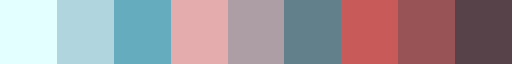

In [30]:
# All colors to create a complete legend
all_colors = ['#e3ffff', '#b0d5df', '#64acbe', '#e4acac', '#ad9ea5', '#627f8c', '#c85a5a', '#985356', '#574249']
cmap = matplotlib.colors.ListedColormap(all_colors)
cmap

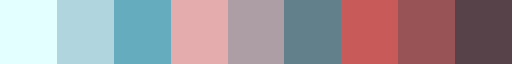

In [31]:
# Set of colors matching the elements of Bi_Class
# We have to exclude those that did not come up in the data
colors = ['#e3ffff', # 1A
          '#b0d5df', # 1B
          '#64acbe', # 1C
          '#e4acac', # 2A
          '#ad9ea5', # 2B
          '#627f8c', # 2C
          '#c85a5a', # 3A
          '#985356', # 3B
          '#574249'] # 3C
            
cmap = matplotlib.colors.ListedColormap(colors)
cmap

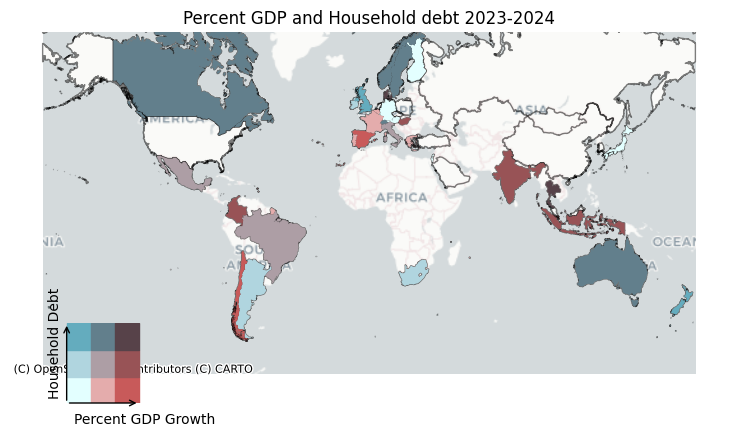

In [32]:
fig, ax = plt.subplots(figsize=(8,8))
# Step 1: Draw the map
border.to_crs('EPSG:3857').plot(ax=ax, facecolor='none', edgecolor='black', alpha=.5) # city border
data.to_crs('EPSG:3857').plot(ax=ax, 
                              column='Bi_Class', # variable that is going to be used to color the map 
                              cmap=cmap, # newly defined bivariate cmap 
                              categorical=True, # bivariate choropleth has to be colored as categorical map 
                              legend=False) # we're going to draw the legend ourselves
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron) # add the basemap

ax.set_ylim(-9576560.99157736, 11476800.060784698)

plt.tight_layout() # "tighten" two figures map and basemap
plt.axis('off') # we don't need axis with coordinates
ax.set_title('Percent GDP and Household debt 2023-2024')

# # Step 2: draw the legend

# We're drawing a 3x3 "box" as 3 columns
# The xmin and xmax arguments axvspan are defined to create equally sized small boxes

img2 = fig # refer to the main figure
ax2 = fig.add_axes([0.15, 0.25, 0.1, 0.1]) # add new axes to place the legend there
                                         # and specify its location 
alpha = 1 # alpha argument to make it more/less transperent


# Column 1
ax2.axvspan(xmin=0, xmax=0.33, ymin=0, ymax=0.33, alpha=alpha, color=all_colors[0])
ax2.axvspan(xmin=0, xmax=0.33, ymin=0.33, ymax=0.66, alpha=alpha, color=all_colors[1])
ax2.axvspan(xmin=0, xmax=0.33, ymin=0.66, ymax=1, alpha=alpha, color=all_colors[2])

# Column 2
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0, ymax=0.33, alpha=alpha, color=all_colors[3])
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0.33, ymax=0.66, alpha=alpha, color=all_colors[4])
ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0.66, ymax=1, alpha=alpha, color=all_colors[5])

# Column 3
ax2.axvspan(xmin=0.66, xmax=1, ymin=0, ymax=0.33, alpha=alpha, color=all_colors[6])
ax2.axvspan(xmin=0.66, xmax=1, ymin=0.33, ymax=0.66, alpha=alpha, color=all_colors[7])
ax2.axvspan(xmin=0.66, xmax=1, ymin=0.66, ymax=1, alpha=alpha, color=all_colors[8])
# Step 3: annoate the legend
ax2.tick_params(axis='both', which='both', length=0) # remove ticks from the big box
ax2.axis('off'); # turn off its axis
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1)) # draw arrow for x 
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1)) # draw arrow for y 
ax2.text(s='Percent GDP Growth', x=0.1, y=-0.25) # annotate x axis
ax2.text(s='Household Debt', x=-0.25, y=0.1, rotation=90); # annotate y axis
plt.savefig('bivariate_choropleth.png', dpi=300)

# print(ax.get_ylim()[0])
# print(ax.get_ylim()[1])